**Student Name: Muhammad Umer Farooq**

**Student ID: 22402098**

# Assignment 1: Image SuperResolution

In this Assignment we will attempt to perform super-resolution with a convolutional neural network. [Super-resolution](https://wiki.tum.de/display/lfdv/Super-Resolution) involves upsampling a low resolution image to a higher resolution.

This notebook loads the Training/Validataion data from the [DIV2K dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/). This dataset provides 800 high resolution images and various low resolution versions of the images. For this Assignment we will use the low resolution images that have been downsampled by a factor of 4 (using bicubic interpolation). The high resolution images are the ground truth and the low resolution images are the input to the network.

As there are few training images and also because the images are so large, it is better for training neural networks to to extract patches from the images to train on. Using this methodology is possible to increase the training set to 10's or 100's of thousands of images. This notebook already has code to perform patch generation for you. The patch generation is time consuming so the patches can be stored your Google drive and loaded the next time you start the notebook.

In this Assignment you are encouraged to explore different approaches to building Convolutional Neural Networks for Super-resolution. It is important to note that with Neural Networks there is often no "right" answer, many different approaches will perform similarly. A good staring place is to use the approach the work of Dong et al in their paper ["Image super-resolution using deep convolutional networks"](https://arxiv.org/pdf/1501.00092.pdf). There are more approaches detailed in the review of super-resolution by [Wang 2020](https://arxiv.org/pdf/1902.06068.pdf). (Just note that many of the approaches detailed in this paper are quite advanced and exceed the scope of what we will cover in this module. It is best to restrict your network to use Convolution/upsampling layers and a simple loss function. A key learning outcome from the assignment is to get comfortable with the Keras Tensorflow API and be able to build and train your own network, so there no expectation to develop exotic architectures (please see assignment rubric on course site))


The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) are useful for this Assignment.  


#Configuration

Import Libraries

In [1]:
from __future__ import print_function

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2
import numpy as np
import glob
import random

Configure Parameters

In [2]:
batch_size = 16      # Number of batches to use (set to maximise GPU RAM use)
HW_trg =224          # Default size of patches from 2K images
ds = 4               # Downsample Factor from High resolution to Lower Resolution iamges

write_train_patch_dir_HR = 'root/.keras/datasets/DIV2K_train_patch_HR/'
write_train_patch_dir_LR = 'root/.keras/datasets/DIV2K_train_patch_LR/'
write_test_patch_dir_HR = 'root/.keras/datasets/DIV2K_test_patch_HR/'
write_test_patch_dir_LR = 'root/.keras/datasets/DIV2K_test_patch_LR/'

To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

Mount Google to read/write tar.gz files containing patches

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Helper functions used in the notebook

In [5]:
# Function for Calculating PSNR.
def calc_psnr(img1,img2):
    img1 = tf.cast(img1,tf.float32)
    img2 = tf.cast(img2,tf.float32)
    size_img = np.shape(img1)
    mse = tf.math.reduce_sum((tf.cast(img1,tf.float32)-tf.cast(img2,tf.float32))**2)/(size_img[0]**2)
    # Place limitation on min MSE so that can't get inf (limit to 47)
    mse = tf.math.maximum(mse,0.000000001)
    psnr = 10*tf.experimental.numpy.log10((255**2)/mse)
    return psnr

# Clip Only
def norm_chns(img):
  img = np.clip(img,0,255)
  return img

# Image Content test (look for High freqency content)
def _img_hf(img):
      img_float = tf.cast(img,tf.float32)
      grey_img = tf.expand_dims(tf.expand_dims(0.2989*img_float[:,:,0]+0.5870*img_float[:,:,1]+0.1140*img_float[:,:,2],axis=0),axis=3)
      log_kernel = tf.expand_dims(tf.expand_dims([[0.0,-1.0,0.0],[-1.0,4.0,-1.0],[0.0,-1.0,0.0]],axis=2),axis=3)
      conv_log = tf.nn.convolution(grey_img,log_kernel)
      patch_max = tf.math.reduce_max(conv_log)
      return patch_max


# Plot Comparisions between models and ground truth.
def plot_results(n_img,cf_models=False):
    # Limit max plots to single batch size
    n_img = np.min([n_img,batch_size])


    # Obtain a single batch from the dataset
    for image_batch,gt_batch in test_dataset.take(1):
       # Obtain predictions from models
       bicubic_imgs = baseline_model.predict_on_batch(image_batch)
       if cf_models == True:
          predictions = my_model.predict_on_batch(image_batch)

       # Define Plot
       fig = plt.figure(figsize=(20, 10))
       dims = int(np.ceil(np.sqrt(n_img)))
       if cf_models == True:
         dims = int(np.ceil(np.sqrt(3*n_img)))
       else:
         dims = int(np.ceil(np.sqrt(2*n_img)))

       # Function to plot sub image (Ensure normalised and 8 bit)
       def sub_plot_img(img,plt_str,plt_no,norm=True):
         if norm==True:
           ssim = tf.image.ssim(tf.expand_dims(img, axis=0),tf.expand_dims(tf.cast(gt_img,tf.float32), axis=0),255.0)
           psnr = calc_psnr(img,gt_img)
           psnr_disp = str(float(psnr))[0:4]
           ssim_disp = str(float(ssim))[0:4]
           patch_err = _img_hf(img)         # Remove patch error later
           img = norm_chns(img)             # Norm for display after PSRN calc
           img = tf.cast(img,tf.uint8)
           plt_str = plt_str+'\n'+'PSNR = '+psnr_disp+' dB '+'\n'+' SSIM = '+ssim_disp

         ax = fig.add_subplot(dims, dims, plt_no, xticks=[], yticks=[])
         ax.title.set_text(plt_str)
         ax.imshow(img[:,:,:])

       # Iterate over number of images Plot & Include PSNR
       cntr = 0
       for i in range(n_img):
          # Plot Ground Truth
          gt_img = gt_batch[i,:,:,:]
          patch_err = _img_hf(gt_img)
          sub_plot_img(gt_img,'Ground truth ',cntr+1,norm=False)
          # Plot Bicubic
          bc_img = bicubic_imgs[i,:,:,:]
          sub_plot_img(bc_img,'Bicubic ',cntr+2,norm=True)
          #
          if cf_models == True:
            my_img = predictions[i,:,:,:]
            sub_plot_img(my_img,'My Model ',cntr+3,norm=True)
            cntr +=3
          else:
            cntr +=2
       plt.tight_layout()

# Evaluate PSNR on Test Set for baseline and my_model
def eval_metrics():
  store_bc_psnr =[]
  store_my_psnr =[]
  store_bc_ssim =[]
  store_my_ssim =[]
  store_delta_psnr = []
  store_delta_ssim = []
  for image_batch,gt_batch in test_dataset.take(50):
    bicubic_imgs = baseline_model.predict_on_batch(image_batch)
    predictions = my_model.predict_on_batch(image_batch)
    # Need to be able to normalise and calculate PSNR over batches
    cntr = 0
    for gt_img in gt_batch:
       bc_img = bicubic_imgs[cntr,:,:,:]
       bc_psnr = calc_psnr(bc_img,gt_img)
       bc_ssim = tf.image.ssim(tf.expand_dims(bc_img, axis=0),tf.expand_dims(tf.cast(gt_img,tf.float32), axis=0),255.0)
       # Reject low std images as are flat with high PSNR (no errors)
       #patch_err = tf.math.reduce_std(tf.cast(gt_img,tf.float32))
       if bc_psnr < 100:
         store_bc_psnr.append(float(bc_psnr))
         store_bc_ssim.append(float(bc_ssim))
         my_img = predictions[cntr,:,:,:]
         my_psnr = calc_psnr(my_img,gt_img)
         my_ssim = tf.image.ssim(tf.expand_dims(my_img, axis=0),tf.expand_dims(tf.cast(gt_img,tf.float32), axis=0),255.0)
         store_my_psnr.append(float(my_psnr))
         store_my_ssim.append(float(my_ssim))
         store_delta_psnr.append(float(my_psnr)-float(bc_psnr))
         store_delta_ssim.append(float(my_ssim)-float(bc_ssim))
       cntr += 1
  store_bc_psnr =store_bc_psnr[1:]
  store_my_psnr =store_my_psnr[1:]
  store_bc_ssim =store_bc_ssim[1:]
  store_my_ssim =store_my_ssim[1:]
  print('Mean PSNR improvement = ',np.mean(store_delta_psnr), ' dB')
  print('Mean SSIM improvement = ',np.mean(store_delta_ssim))
  # Matplot lib histogram of deltas.
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 8))
  bins = np.linspace(5, 60,num=50)
  ax0.hist(store_bc_psnr,bins)
  ax0.set_title('PSNR Bicubic, Mean ='+str(np.mean(store_bc_psnr)))
  ax1.hist(store_my_psnr,bins)
  ax1.set_title('PSNR My Model, Mean ='+str(np.mean(store_my_psnr)))
  bins = np.linspace(-6, 4,num=50)
  ax2.hist(store_delta_psnr,bins)
  ax2.set_title('Difference in PSNR')
  plt.show

  figb, (axb0, axb1, axb2) = plt.subplots(nrows=3, figsize=(8, 8))
  bins = np.linspace(-1, 1,num=50)
  axb0.hist(store_bc_ssim,bins)
  axb0.set_title('SSIM Bicubic, Mean ='+str(np.mean(store_bc_ssim)))
  axb1.hist(store_my_ssim,bins)
  axb1.set_title('SSIM My Model, Mean ='+str(np.mean(store_my_ssim)))
  axb2.hist(store_delta_ssim,bins)
  axb2.set_title('Difference in SSIM')
  plt.show

#1. Load Dataset

 Load 2K image dataset and convert to smaller patches. **You only need to run this step the first time you use this notebook**. The code will store a tar.gz file with the extracted patches in your google drive. You can then recover the patches the next time you use the notebook.

 (Note that if you want to change the number/size of the patches you will need to run the code again)

In [6]:
TRAIN_DATA_URL_HR = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip'
TEST_DATA_URL_HR = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'
TRAIN_DATA_URL_LR = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip'
TEST_DATA_URL_LR = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'

train_path = tf.keras.utils.get_file('DIV2K_train_HR.zip',origin=TRAIN_DATA_URL_HR,extract=True)
test_path = tf.keras.utils.get_file('DIV2K_valid_HR.zip',origin=TEST_DATA_URL_HR,extract=True)
train_path = tf.keras.utils.get_file('DIV2K_train_LR_bicubic_X4.zip',origin=TRAIN_DATA_URL_LR,extract=True)
test_path = tf.keras.utils.get_file('DIV2K_valid_LR_bicubic_X4.zip',origin=TEST_DATA_URL_LR,extract=True)
#!ls /root/.keras/datasets/DIV2K_train_HR
#!ls /root/.keras/datasets/DIV2K_train_LR_bicubic/X4/

  38051840/3530603713 [..............................] - ETA: 5:07

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-457d0f46840d>", line 6, in <cell line: 6>
    train_path = tf.keras.utils.get_file('DIV2K_train_HR.zip',origin=TRAIN_DATA_URL_HR,extract=True)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 347, in get_file
    urlretrieve(origin, fpath, DLProgbar())
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 87, in urlretrieve
    for chunk in chunk_read(response, reporthook=reporthook):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 76, in chunk_read
    chunk = response.read(chunk_size)
  File "/usr/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b

TypeError: ignored

In [ ]:
!ls /root/.keras/datasets/DIV2K_train_LR_bicubic/X4/

0001x4.png  0135x4.png	0269x4.png  0403x4.png	0537x4.png  0671x4.png
0002x4.png  0136x4.png	0270x4.png  0404x4.png	0538x4.png  0672x4.png
0003x4.png  0137x4.png	0271x4.png  0405x4.png	0539x4.png  0673x4.png
0004x4.png  0138x4.png	0272x4.png  0406x4.png	0540x4.png  0674x4.png
0005x4.png  0139x4.png	0273x4.png  0407x4.png	0541x4.png  0675x4.png
0006x4.png  0140x4.png	0274x4.png  0408x4.png	0542x4.png  0676x4.png
0007x4.png  0141x4.png	0275x4.png  0409x4.png	0543x4.png  0677x4.png
0008x4.png  0142x4.png	0276x4.png  0410x4.png	0544x4.png  0678x4.png
0009x4.png  0143x4.png	0277x4.png  0411x4.png	0545x4.png  0679x4.png
0010x4.png  0144x4.png	0278x4.png  0412x4.png	0546x4.png  0680x4.png
0011x4.png  0145x4.png	0279x4.png  0413x4.png	0547x4.png  0681x4.png
0012x4.png  0146x4.png	0280x4.png  0414x4.png	0548x4.png  0682x4.png
0013x4.png  0147x4.png	0281x4.png  0415x4.png	0549x4.png  0683x4.png
0014x4.png  0148x4.png	0282x4.png  0416x4.png	0550x4.png  0684x4.png
0015x4.png  0149x4.png	0283x4.png 

Function to Read 2K Images sequentially and write patches to directory.
The low resolution images are smaller, so a downsampled patch size is obtained.

In [7]:
# Subfunction to read file and extract patches
def _read_extract(fid,read_dir,f_ext,LR):
    # Read image string
    img_str = read_dir+str(fid).zfill(4)+f_ext
    # Read Image
    img1_file = tf.io.read_file(img_str)
    real_image =tf.expand_dims(tf.io.decode_png(img1_file,channels=3),axis=0)
    # Extract patches (different size/stride depending HR/LR)
    if LR == True:
       ext_patches = tf.image.extract_patches(images=real_image,sizes=[1,56,56,1],strides=[1,50,50,1],rates=[1,1,1,1],padding='VALID')
    else:
       ext_patches = tf.image.extract_patches(images=real_image,sizes=[1,224,224,1],strides=[1,200,200,1],rates=[1,1,1,1],padding='VALID')
    shape=tf.shape(ext_patches)
    ext_patches = tf.reshape(tf.squeeze(ext_patches),[shape[1]*shape[2],shape[3]])
    return ext_patches

# Subfunction calculates standard deviation of an image (converts to greysale)
def _img_std(img):
      img_float = tf.cast(img,tf.float32)
      grey_img = 0.2989*img_float[:,:,0]+0.5870*img_float[:,:,1]+0.1140*img_float[:,:,2]
      patch_std = tf.math.reduce_std(tf.cast(grey_img,tf.float32))
      return patch_std

# Subfunction applies Laplacian of gaussian to patches to identify blurred images
# Principle of estimating high freqency content of image with LoG
def _img_hf(img):
      img_float = tf.cast(img,tf.float32)
      grey_img = tf.expand_dims(tf.expand_dims(0.2989*img_float[:,:,0]+0.5870*img_float[:,:,1]+0.1140*img_float[:,:,2],axis=0),axis=3)
      log_kernel = tf.expand_dims(tf.expand_dims([[0.0,-1.0,0.0],[-1.0,4.0,-1.0],[0.0,-1.0,0.0]],axis=2),axis=3)
      conv_log = tf.nn.convolution(grey_img,log_kernel)
      patch_max = tf.math.reduce_max(conv_log)
      return patch_max

# Subfunction to reshape (different depending if HR or LR)
def _reshape_patch(ser_img,LR):
      # Reshape each patch
      if LR == True:
        img_patch = tf.reshape(ser_img,[56,56,3])
      else:
        img_patch = tf.reshape(ser_img,[224,224,3])
      return img_patch

# Subfunction to write patch to correct directory
def _write_patch(img_patch,write_dir,fid):
        # Encode patch to png
        img_file = tf.io.encode_png( img_patch)
        # Write to file in order
        tf.io.write_file((write_dir+str(fid).zfill(6)+'.png'),img_file)



def read_write(read_dir_HR,read_dir_LR,write_dir_HR,write_dir_LR,f_ext_HR,f_ext_LR,n_start,n_stop):
  cntr =0
  for i in tqdm(range(n_start,n_stop)):
    # Read Patches Sequentially & Simulataneously from LR/HR directories.
    ext_patches_HR = _read_extract(i,read_dir_HR,f_ext_HR,False)
    ext_patches_LR = _read_extract(i,read_dir_LR,f_ext_LR,True)
    # Iterate patches encode and write to file in new directory
    k =0
    for ser_img_HR  in ext_patches_HR:
       # reshape serial images
       img_patch_HR = _reshape_patch(ser_img_HR,False)
       ser_img_LR = ext_patches_LR[k,:]
       img_patch_LR = _reshape_patch(ser_img_LR,True)
       k+=1
       # Only write patches with high standard deviation (avoid flat images)
       patch_amp = _img_hf(tf.image.central_crop(img_patch_HR,0.75))
       if patch_amp > 100:
         _write_patch(img_patch_HR,write_dir_HR,cntr)
         _write_patch(img_patch_LR,write_dir_LR,cntr)
         cntr+=1



In [ ]:
read_train_dir_HR= '/root/.keras/datasets/DIV2K_train_HR/'
read_train_dir_LR=  '/root/.keras/datasets/DIV2K_train_LR_bicubic/X4/'
read_test_dir_HR= '/root/.keras/datasets/DIV2K_valid_HR/'
read_test_dir_LR=  '/root/.keras/datasets/DIV2K_valid_LR_bicubic/X4/'

read_write(read_train_dir_HR,read_train_dir_LR,write_train_patch_dir_HR,write_train_patch_dir_LR,'.png','x4.png',1,800)
read_write(read_test_dir_HR,read_test_dir_LR,write_test_patch_dir_HR,write_test_patch_dir_LR,'.png','x4.png',801,889)
#!ls /root/.keras/datasets/DIV2K_test_patch_HR

100%|██████████| 88/88 [02:14<00:00,  1.53s/it]


Use [tar](https://www.hostdime.com/kb/hd/command-line/how-to-tar-untar-and-zip-files) to compress directory of patches

In [ ]:
# Compress Patches
!tar cvfz train_patches_HR.tar.gz root/.keras/datasets/DIV2K_train_patch_HR
!tar cvfz train_patches_LR.tar.gz root/.keras/datasets/DIV2K_train_patch_LR
!tar cvfz test_patches_HR.tar.gz root/.keras/datasets/DIV2K_test_patch_HR
!tar cvfz test_patches_LR.tar.gz root/.keras/datasets/DIV2K_test_patch_LR

Streaming output truncated to the last 5000 lines.
root/.keras/datasets/DIV2K_test_patch_HR/000834.png
root/.keras/datasets/DIV2K_test_patch_HR/000645.png
root/.keras/datasets/DIV2K_test_patch_HR/002694.png
root/.keras/datasets/DIV2K_test_patch_HR/000806.png
root/.keras/datasets/DIV2K_test_patch_HR/001022.png
root/.keras/datasets/DIV2K_test_patch_HR/000734.png
root/.keras/datasets/DIV2K_test_patch_HR/002274.png
root/.keras/datasets/DIV2K_test_patch_HR/002227.png
root/.keras/datasets/DIV2K_test_patch_HR/003370.png
root/.keras/datasets/DIV2K_test_patch_HR/000392.png
root/.keras/datasets/DIV2K_test_patch_HR/001785.png
root/.keras/datasets/DIV2K_test_patch_HR/003646.png
root/.keras/datasets/DIV2K_test_patch_HR/001131.png
root/.keras/datasets/DIV2K_test_patch_HR/000224.png
root/.keras/datasets/DIV2K_test_patch_HR/003750.png
root/.keras/datasets/DIV2K_test_patch_HR/003403.png
root/.keras/datasets/DIV2K_test_patch_HR/001575.png
root/.keras/datasets/DIV2K_test_patch_HR/000411.png
root/.keras/d

\**Create a directory "DIV2K_train_patch" in your google drive before copying the tar.gz file**

In [ ]:
# Copy Patches to Google Drive
!cp train_patches_HR.tar.gz '/content/drive/My Drive/DIV2K_train_patch/'
!cp test_patches_HR.tar.gz '/content/drive/My Drive/DIV2K_train_patch/'
!cp train_patches_LR.tar.gz '/content/drive/My Drive/DIV2K_train_patch/'
!cp test_patches_LR.tar.gz '/content/drive/My Drive/DIV2K_train_patch/'

In [ ]:
!ls '/content/drive/My Drive/DIV2K_train_patch/'

ls: cannot access '/content/drive/My Drive/DIV2K_train_patch/': No such file or directory


#1. Alternative Load Dataset.

If you have run part 1 in a previous notebook session and saved tar.gz files to your google drive. Then uncomment and run the code cell below instead of running part 1.

In [8]:
# Check Files Are present in Google Drive
!ls '/content/drive/My Drive/DIV2K_train_patch/'
# Uncompress files
!tar xvfz '/content/drive/My Drive/DIV2K_train_patch/train_patches_HR.tar.gz'
!tar xvfz '/content/drive/My Drive/DIV2K_train_patch/test_patches_HR.tar.gz'
!tar xvfz '/content/drive/My Drive/DIV2K_train_patch/train_patches_LR.tar.gz'
!tar xvfz '/content/drive/My Drive/DIV2K_train_patch/test_patches_LR.tar.gz'
# verify Directory
!ls root/.keras/datasets/DIV2K_test_patch_HR

Streaming output truncated to the last 5000 lines.
root/.keras/datasets/DIV2K_train_patch_LR/027730.png
root/.keras/datasets/DIV2K_train_patch_LR/033912.png
root/.keras/datasets/DIV2K_train_patch_LR/028669.png
root/.keras/datasets/DIV2K_train_patch_LR/012120.png
root/.keras/datasets/DIV2K_train_patch_LR/006629.png
root/.keras/datasets/DIV2K_train_patch_LR/007601.png
root/.keras/datasets/DIV2K_train_patch_LR/017460.png
root/.keras/datasets/DIV2K_train_patch_LR/020070.png
root/.keras/datasets/DIV2K_train_patch_LR/033966.png
root/.keras/datasets/DIV2K_train_patch_LR/018078.png
root/.keras/datasets/DIV2K_train_patch_LR/028099.png
root/.keras/datasets/DIV2K_train_patch_LR/027663.png
root/.keras/datasets/DIV2K_train_patch_LR/033454.png
root/.keras/datasets/DIV2K_train_patch_LR/007691.png
root/.keras/datasets/DIV2K_train_patch_LR/028673.png
root/.keras/datasets/DIV2K_train_patch_LR/021475.png
root/.keras/datasets/DIV2K_train_patch_LR/017194.png
root/.keras/datasets/DIV2K_train_patch_LR/006055

#2. Convert Patches to Dataset
The code cell below will convert the image files into a tesorflow dataset.
* The function `gen_patch_list`obtains a list of all image files
* The function `gen_datasets`is the main function that produces the dataset. The tensorflow `from_generator` method uses an iterator function that returns image files as the dataset (datasets are effectively iterators).
* The sub-function `_img_id` is an interator. It returns an image file string for an image each time it is called. A random permutation of the file list is iterated over.
* Additional operations on the dataset are called using `.map(f-name)` in `gen_datasets` function.
* The sub-function `_read_image_patch` reads the file string and decodes the image to a numpy array (tensor).
* The sub-function `image_pipe`applies a crop to the image and stores it as ground truth.

Note that the dataset returns a tensor in the form (X,Y). X which is the input image patch and Y which is the ground truth that is cropped.
* This allows the output of the network to be cropped also and avoids any edge effects due to convolution (etc) when comparison with ground truth is finally performed.
* It also allows compatibilty with the keras .fit method.


In [9]:
def gen_patch_list(train_patch_dir,test_patch_dir):
    # use glob command to find the image files.
    # pair test strings with training sting
    # Use python sorted() to get numerical order
    train_patch_img_list = sorted(glob.glob(train_patch_dir+'/*.png'))
    test_patch_img_list = sorted(glob.glob(test_patch_dir+'/*.png'))
    return train_patch_img_list,test_patch_img_list


train_patch_img_list_HR,train_patch_img_list_LR = gen_patch_list(write_train_patch_dir_HR,write_train_patch_dir_LR)
test_patch_img_list_HR,test_patch_img_list_LR = gen_patch_list(write_test_patch_dir_HR,write_test_patch_dir_LR)


def _read_image_patch(img_str):
    img_str_HR = img_str[0]
    img_str_LR = img_str[1]
    gt_img_file = tf.io.read_file(img_str_HR)  # HR is ground truth
    ip_img_file =  tf.io.read_file(img_str_LR) # LR is input to network
    gt_image = tf.image.decode_jpeg(gt_img_file,channels=3)
    ip_image = tf.image.decode_jpeg(ip_img_file,channels=3)
    return ip_image,gt_image

def image_pipe( ip_image,gt_image):
  # Crop Ground truth to help avoid issues with boundary effects
  gt_image = tf.image.central_crop(gt_image,0.75)
  return ip_image,gt_image

def gen_datasets(train_patch_img_list,test_patch_img_list):
    def _img_id():
       no_files = len(train_patch_img_list)
       fid_list=np.random.permutation(no_files)
       k =0
       # Choose an image at random for input image_list
       while k<no_files:
          #no_files=len(train_patch_img_list)
          #fid = random.randint(0,no_files-10)
          fid = fid_list[k]
          img_str_HR = train_patch_img_list[fid]
          img_str_LR = test_patch_img_list[fid]
          k+=1
          yield [img_str_HR,img_str_LR]
    # Define Training Datasets (note that in this case batch size is set with parameters
    train_dataset = tf.data.Dataset.from_generator(_img_id,tf.string)
    train_dataset = train_dataset.map(_read_image_patch)
    train_dataset = train_dataset.map(image_pipe)
    train_dataset = train_dataset.batch(batch_size)
    return train_dataset


In [10]:
# Generate Dataset
train_dataset=gen_datasets(train_patch_img_list_HR,train_patch_img_list_LR)
test_dataset=gen_datasets(test_patch_img_list_HR,test_patch_img_list_LR)

In [11]:
# Verify number of patches in dataset
print('No. Train Patches = ',len(train_patch_img_list_LR))
print('No. Test Patches = ',len(test_patch_img_list_LR))

No. Train Patches =  34684
No. Test Patches =  4075


# 3. Baseline Model

In the first code cell below a default model is supplied that increases the resolution of the input data using bi-cubic interpolation. The keras [Resizing layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) with bicubic interpolation can be used to implement this. **This model acts as a baseline** to compare the performance of your model. Note that the a [cropping](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Cropping2D) layer is added to make the output of the model the same size as the ground truth. This avoids any edge effects produced during the interpolation process affecting the loss function and PSNR calculations. Note the [functional API]((https://www.tensorflow.org/guide/keras/functional)) to coding a model is used for the baseline model. It is recommended to continue to use the [functional API]((https://www.tensorflow.org/guide/keras/functional)) for you own model coding.




In [12]:
# Baseline Bicubic Model

# Define Input
img_inputs = keras.Input(shape=(56, 56, 3))
# Bicubic Interpolation
us_out=tf.keras.layers.Resizing(HW_trg,HW_trg,interpolation='bicubic')(img_inputs)
# Crop to remove edge effects (match GT size)
crop_out = tf.keras.layers.Cropping2D(((28, 28), (28, 28)))(us_out)
# Define Model
baseline_model = keras.Model(inputs=img_inputs, outputs=crop_out)

We compile the baseline model, so we can pass test examples through it for later comparison with your own model. We don't need to perform training on the baseline model as it has no parameters (is just a bicubic interpolation & crop).

In [13]:
baseline_model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 56, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 cropping2d (Cropping2D)     (None, 168, 168, 3)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We pass some image patches through the baseline model. You should be able to see the degredation of these images compared to the ground truth due (primarily) to the intial downsampling operation.

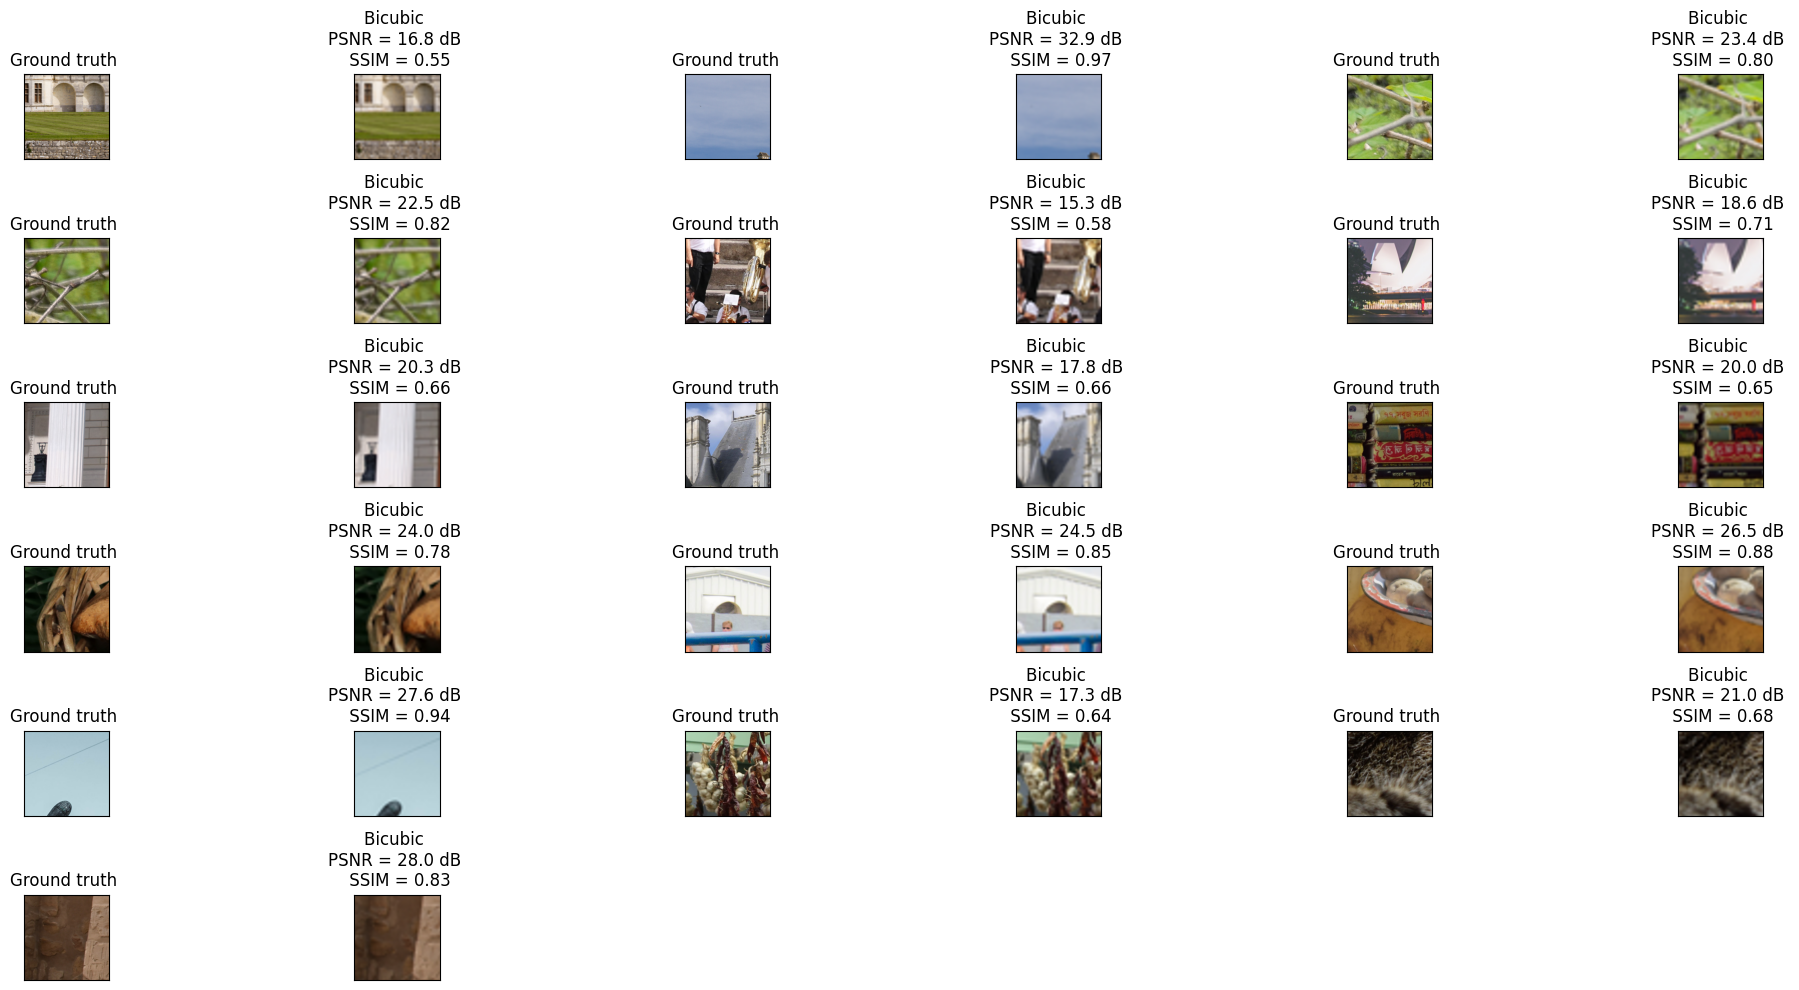

In [14]:
plot_results(16,cf_models=False)

# 4. CNN based Super-resolution Model

In the code cell below you can complete your own model "my_model" needed to perform the super-resolution. You can incorporate the bicubic interpolation as part of your model or use an alternative approach. Use the same output cropping layer as the baseline model to remove edge effects and ensure your output size matches the ground truth. (You may have to adjust the size of the crop, the goal is to have the same output size 168 x 168 as the ground truth)





In [ ]:
# Define Your Model (Ensure that you call your model "my_model" for compatibilty with later plotting function)

# Sequential model will be created as I feel it is more readable
'''
Initially, I will try hyper-parameters mentioned in Dong et al paper
'''
f1 = 9 # 9 x 9 dimension of layer 1 kernel
f2 = 1 # 1 x 1 dimension of layer 2 kernel
f3 = 5 # 5 x 5 diemsion of layer 3 kernel
n1 = 64 # No. of kernels in layer 1
n2 = 32 # No. of kernels in layer 2
n3 = 3 # No. of channel as per RGB

my_model = keras.Sequential([
    keras.layers.Resizing(HW_trg, HW_trg, interpolation='bicubic', input_shape = (56, 56, 3)),
    keras.layers.Conv2D(n1, f1, padding = "same", activation = "relu"),
    keras.layers.Conv2D(n2, f2, padding = "same", activation = "relu"),
    keras.layers.Conv2D(n3, f3, padding = "same", activation = "relu"),
    keras.layers.Cropping2D(((28,28), (28,28)))
])



# Define Input and
#img_inputs = keras.Input(shape=(56, 56, 3))



# Crop to remove edge effects (match GT size)
#crop_out = tf.keras.layers.Cropping2D(((, ), (, )))(us_out)

#my_model = keras.Model(inputs=img_inputs, outputs=crop_out)


# 5. Model Training

In the code cells below you can compile and train your model using Keras Tensorflow API. As mentioned in the introduction the principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials.



In [ ]:
# Compile Model
my_model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam())
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 3)       2403      
                                                                 
 cropping2d_1 (Cropping2D)   (None, 168, 168, 3)       0         
                                                                 
Total params: 20099 (78.51 KB)
Trainable params: 20099 (78.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 15 # You may need additional/fewer epochs depending on your network

history = my_model.fit(train_dataset,epochs=epochs,validation_data=test_dataset)

Epoch 1/15
2168/2168 [==============================] - 183s 81ms/step - loss: 311.8750 - val_loss: 250.1066
Epoch 2/15
2168/2168 [==============================] - 154s 71ms/step - loss: 267.8138 - val_loss: 245.6049
Epoch 3/15
2168/2168 [==============================] - 146s 68ms/step - loss: 265.7904 - val_loss: 248.7156
Epoch 4/15
2168/2168 [==============================] - 150s 69ms/step - loss: 262.5470 - val_loss: 250.6509
Epoch 5/15
2168/2168 [==============================] - 149s 69ms/step - loss: 261.0899 - val_loss: 239.8344
Epoch 6/15
2168/2168 [==============================] - 150s 69ms/step - loss: 263.6246 - val_loss: 241.7213
Epoch 7/15
2168/2168 [==============================] - 149s 69ms/step - loss: 259.4758 - val_loss: 239.4995
Epoch 8/15
2168/2168 [==============================] - 152s 70ms/step - loss: 258.6112 - val_loss: 238.5957
Epoch 9/15
2168/2168 [==============================] - 149s 69ms/step - loss: 257.4514 - val_loss: 239.3138
Epoch 10/15
2168/21

# 6. Evaluation

In the code cell below we will plot the ground truth and the results of bicubic interpolation and the output of your model for a small sample of images. The images should visually show improved resolution over the baseline bicubic model (e.g. clarity of edges).

 The PSNR/SSIM metrics are also calculated for your model output and the bicubic interpolation over the test set. If your model is performing properly then there should be a small consistent improvement in [PSNR/SSIM](https://wiki.tum.de/display/lfdv/Super-Resolution#SuperResolution-PSNR).

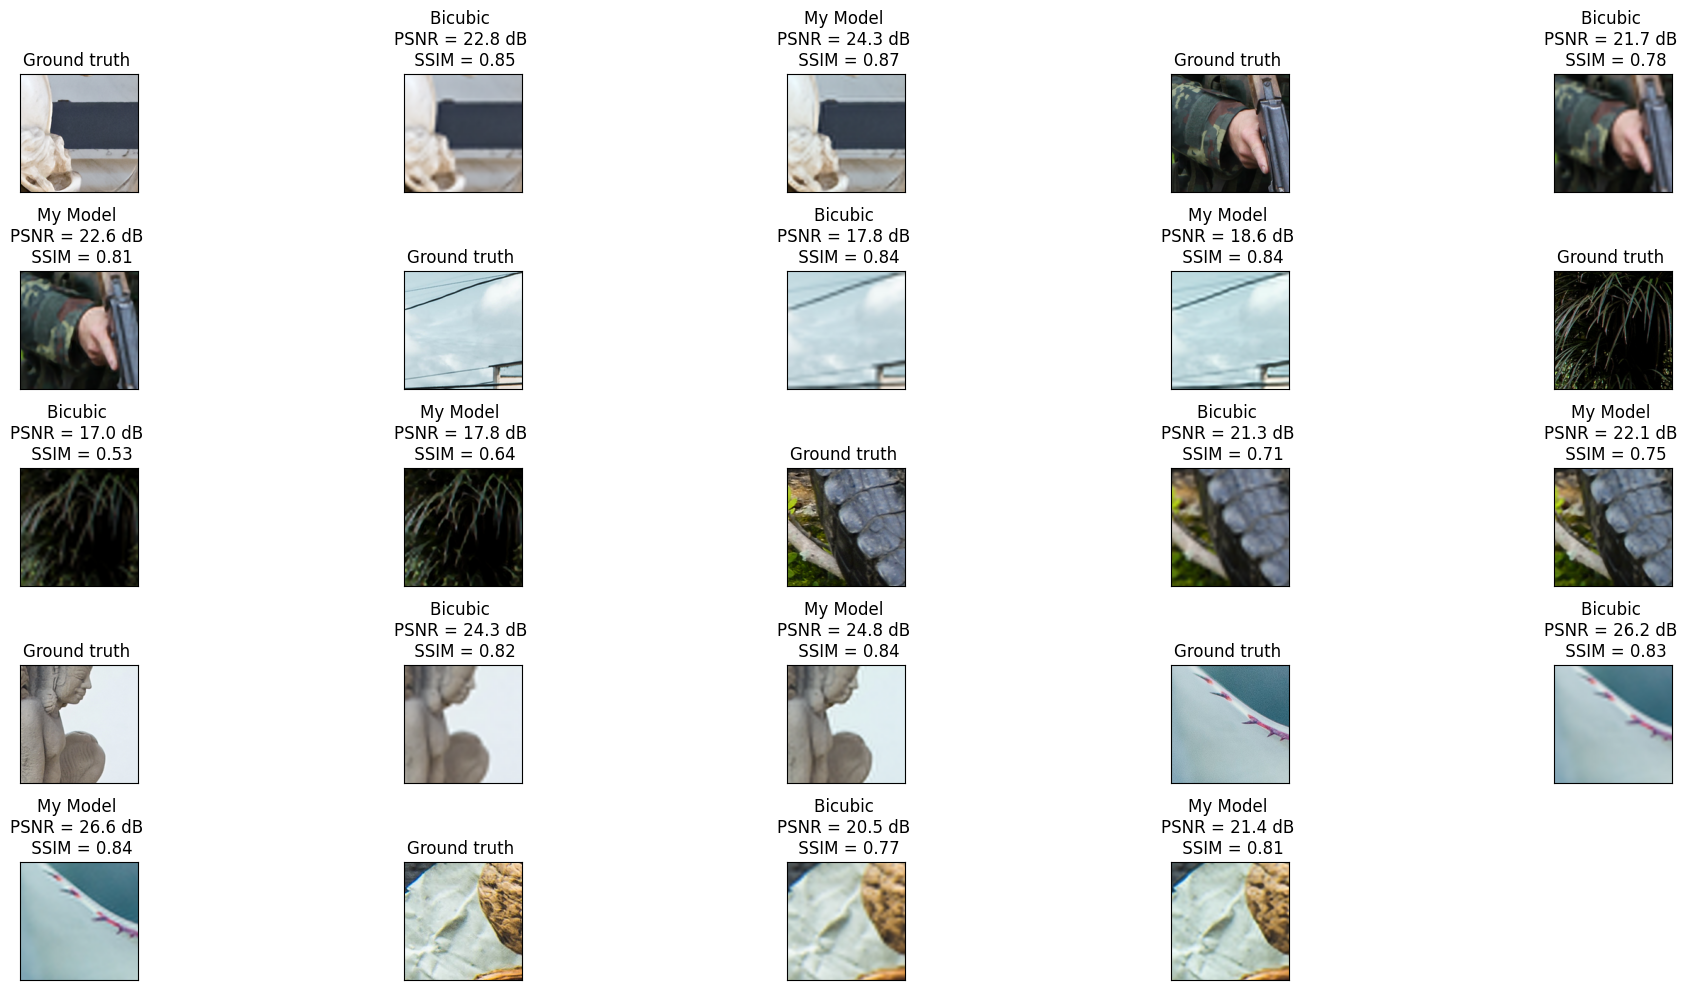

In [ ]:
plot_results(8,cf_models=True)

Mean PSNR improvement =  0.6754801380634308  dB
Mean SSIM improvement =  0.034757881313562396


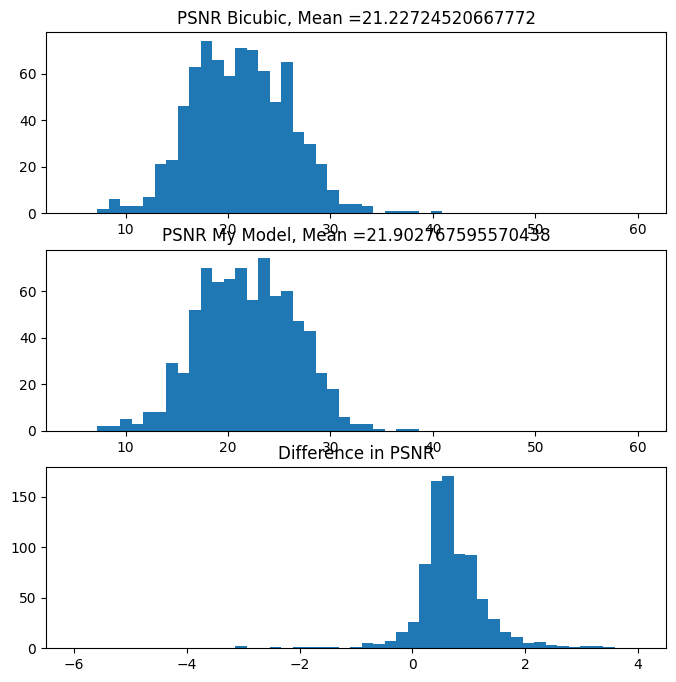

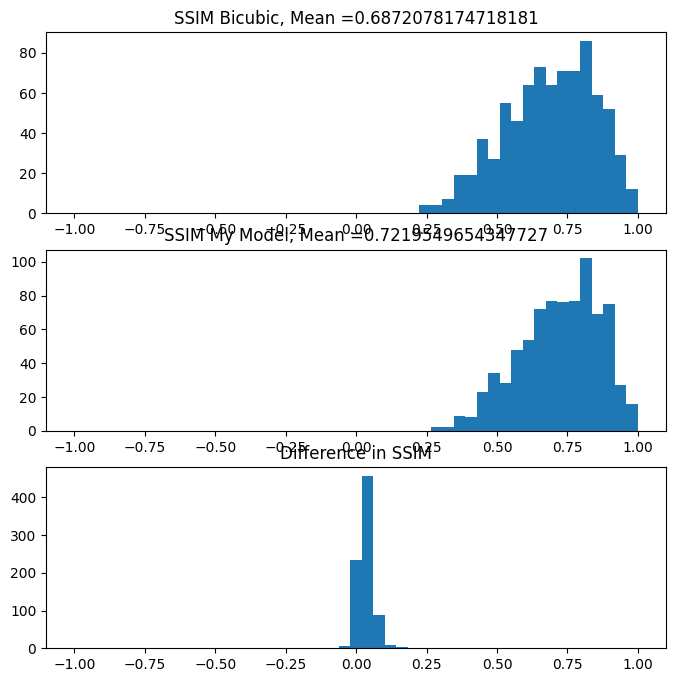

In [ ]:
eval_metrics()

**Visualize training results**
Let's visualize the training results to determine how good the trained model is?

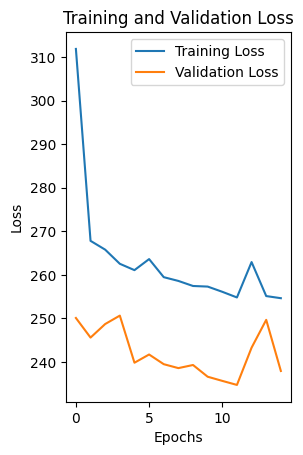

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title('Training and Validation Loss')
plt.show()

The above figure shows that training and validation loss demonstrate similar trend. Hence, the model is not an overfitted model. The above figure also demonstrates that drop in the loss is the greatest going from 1st epoch to the 2nd epoch, afterwards there is no significant difference in loss.

**Analysing the Impact of Increased Number of Filters**

Here, I will recreate the model by increasing the filter size, and see how it impacts the mean PSNR. The number of filters in layer 1 will be increased from 64 to 128, and the number of filters in layer 2 will be increased from 32 to 64. All other hyper-paramater values will remain the same.

In [ ]:
# Define Your Model (Ensure that you call your model "my_model" for compatibilty with later plotting function)

# Sequential model will be created as I feel it is more readable
'''
Initially, I will try hyper-parameters mentioned in Dong et al paper
'''
f1 = 9 # 9 x 9 dimension of layer 1 kernel
f2 = 1 # 1 x 1 dimension of layer 2 kernel
f3 = 5 # 5 x 5 diemsion of layer 3 kernel
n1 = 128 # No. of kernels in layer 1
n2 = 64 # No. of kernels in layer 2
n3 = 3 # No. of channel as per RGB

my_model = keras.Sequential([
    keras.layers.Resizing(HW_trg, HW_trg, interpolation='bicubic', input_shape = (56, 56, 3)),
    keras.layers.Conv2D(n1, f1, padding = "same", activation = "relu"),
    keras.layers.Conv2D(n2, f2, padding = "same", activation = "relu"),
    keras.layers.Conv2D(n3, f3, padding = "same", activation = "relu"),
    keras.layers.Cropping2D(((28,28), (28,28)))
])



In [ ]:
# Compile Model
my_model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam())
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 128)     31232     
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      8256      
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 3)       4803      
                                                                 
 cropping2d_2 (Cropping2D)   (None, 168, 168, 3)       0         
                                                                 
Total params: 44291 (173.01 KB)
Trainable params: 44291 (173.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Previously we have seen that there is no bit change going from epoch 2 onwards, therefore in this training we will only use epochs upto 10
epochs = 10 # You may need additional/fewer epochs depending on your network

history = my_model.fit(train_dataset,epochs=epochs,validation_data=test_dataset)

Epoch 1/10
2168/2168 [==============================] - 236s 107ms/step - loss: 314.0355 - val_loss: 248.9121
Epoch 2/10
2168/2168 [==============================] - 231s 107ms/step - loss: 268.2769 - val_loss: 244.3138
Epoch 3/10
2168/2168 [==============================] - 231s 107ms/step - loss: 263.5717 - val_loss: 240.6515
Epoch 4/10
2168/2168 [==============================] - 231s 106ms/step - loss: 261.2460 - val_loss: 245.0498
Epoch 5/10
2168/2168 [==============================] - 230s 106ms/step - loss: 259.2825 - val_loss: 238.4088
Epoch 6/10
2168/2168 [==============================] - 222s 102ms/step - loss: 257.2404 - val_loss: 237.7359
Epoch 7/10
2168/2168 [==============================] - 222s 102ms/step - loss: 256.3727 - val_loss: 239.4035
Epoch 8/10
2168/2168 [==============================] - 222s 102ms/step - loss: 254.9749 - val_loss: 234.1607
Epoch 9/10
2168/2168 [==============================] - 220s 102ms/step - loss: 263.7131 - val_loss: 245.3624
Epoch 10/1

**Plotting the Results**

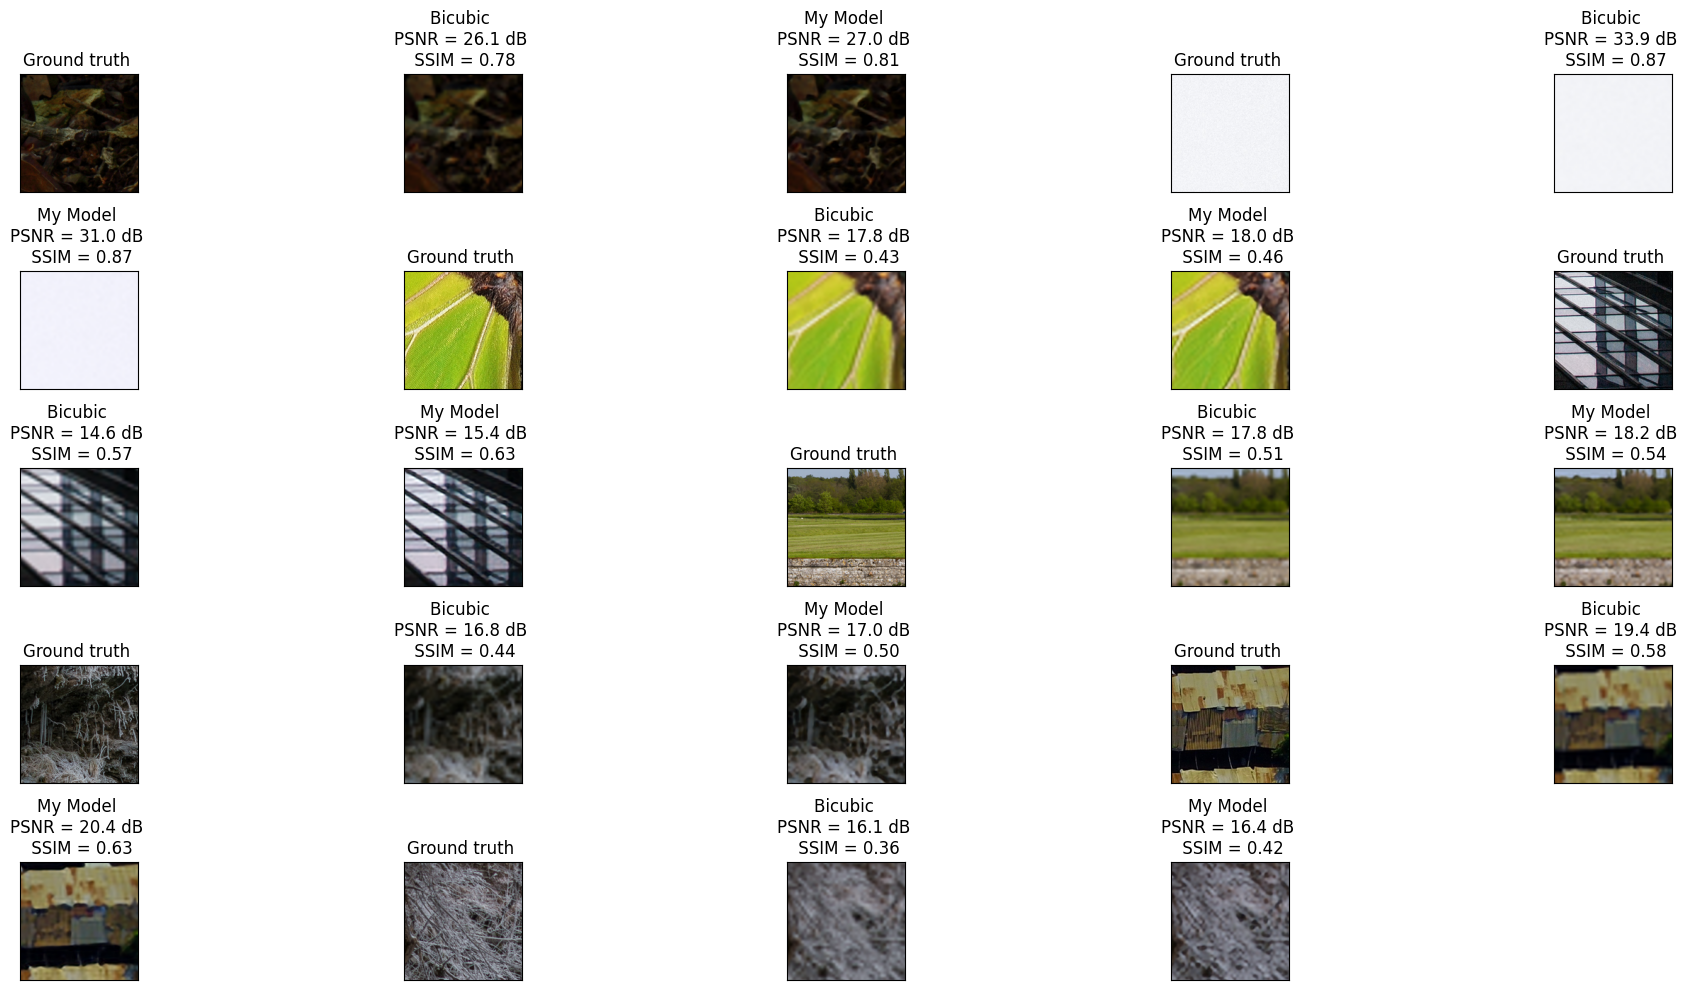

In [ ]:
plot_results(8,cf_models=True)

**Evaluating the Model**

Mean PSNR improvement =  0.6587233078479767  dB
Mean SSIM improvement =  0.03093932433053851


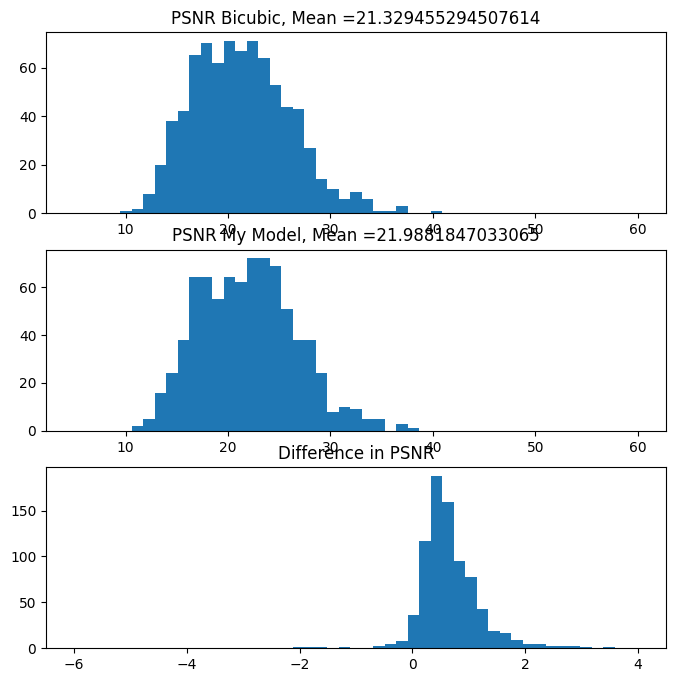

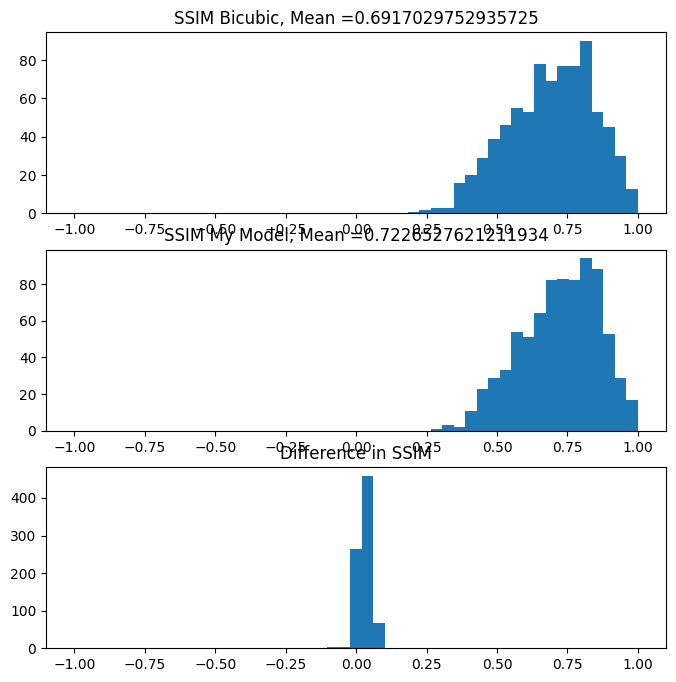

In [ ]:
eval_metrics()

Increasing the number of filters nor imporve PSNR neither it improves SSIM. In fact, the increase in the number of filters slightly drops PSNR and SSIM. In the next model, I will try to explore the impact of filter size on the performance.

Analysing the Impact of Increasing a filter spatial size.
Here, f2 will be increased from 1 to 5, and f1 and f3 shall be kept the same.

In [ ]:
# Define Your Model (Ensure that you call your model "my_model" for compatibilty with later plotting function)

# Sequential model will be created as I feel it is more readable
'''
Initially, I will try hyper-parameters mentioned in Dong et al paper
'''
f1 = 9 # 9 x 9 dimension of layer 1 kernel
f2 = 5 # 1 x 1 dimension of layer 2 kernel
f3 = 5 # 5 x 5 diemsion of layer 3 kernel
n1 = 64 # No. of kernels in layer 1
n2 = 32 # No. of kernels in layer 2
n3 = 3 # No. of channel as per RGB

my_model = keras.Sequential([
    keras.layers.Resizing(HW_trg, HW_trg, interpolation='bicubic', input_shape = (56, 56, 3)),
    keras.layers.Conv2D(n1, f1, padding = "same", activation = "relu"),
    keras.layers.Conv2D(n2, f2, padding = "same", activation = "relu"),
    keras.layers.Conv2D(n3, f3, padding = "same", activation = "relu"),
    keras.layers.Cropping2D(((28,28), (28,28)))
])

In [ ]:
# Compile Model
my_model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam())
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      15616     
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      51232     
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 3)       2403      
                                                                 
 cropping2d_3 (Cropping2D)   (None, 168, 168, 3)       0         
                                                                 
Total params: 69251 (270.51 KB)
Trainable params: 69251 (270.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Previously we have seen that there is no bit change going from epoch 2 onwards, therefore in this training we will only use epochs upto 10
epochs = 10 # You may need additional/fewer epochs depending on your network

history = my_model.fit(train_dataset,epochs=epochs,validation_data=test_dataset)

Epoch 1/10
2168/2168 [==============================] - 208s 94ms/step - loss: 316.6655 - val_loss: 250.4243
Epoch 2/10
2168/2168 [==============================] - 203s 94ms/step - loss: 272.1113 - val_loss: 243.7051
Epoch 3/10
2168/2168 [==============================] - 212s 98ms/step - loss: 268.2440 - val_loss: 242.6042
Epoch 4/10
2168/2168 [==============================] - 213s 98ms/step - loss: 263.7426 - val_loss: 241.3613
Epoch 5/10
2168/2168 [==============================] - 204s 94ms/step - loss: 260.6933 - val_loss: 244.4162
Epoch 6/10
2168/2168 [==============================] - 205s 94ms/step - loss: 270.0488 - val_loss: 243.3094
Epoch 7/10
2168/2168 [==============================] - 201s 93ms/step - loss: 261.2673 - val_loss: 240.1401
Epoch 8/10
2168/2168 [==============================] - 201s 93ms/step - loss: 260.1057 - val_loss: 238.4379
Epoch 9/10
2168/2168 [==============================] - 211s 97ms/step - loss: 259.0213 - val_loss: 241.6046
Epoch 10/10
2168/21

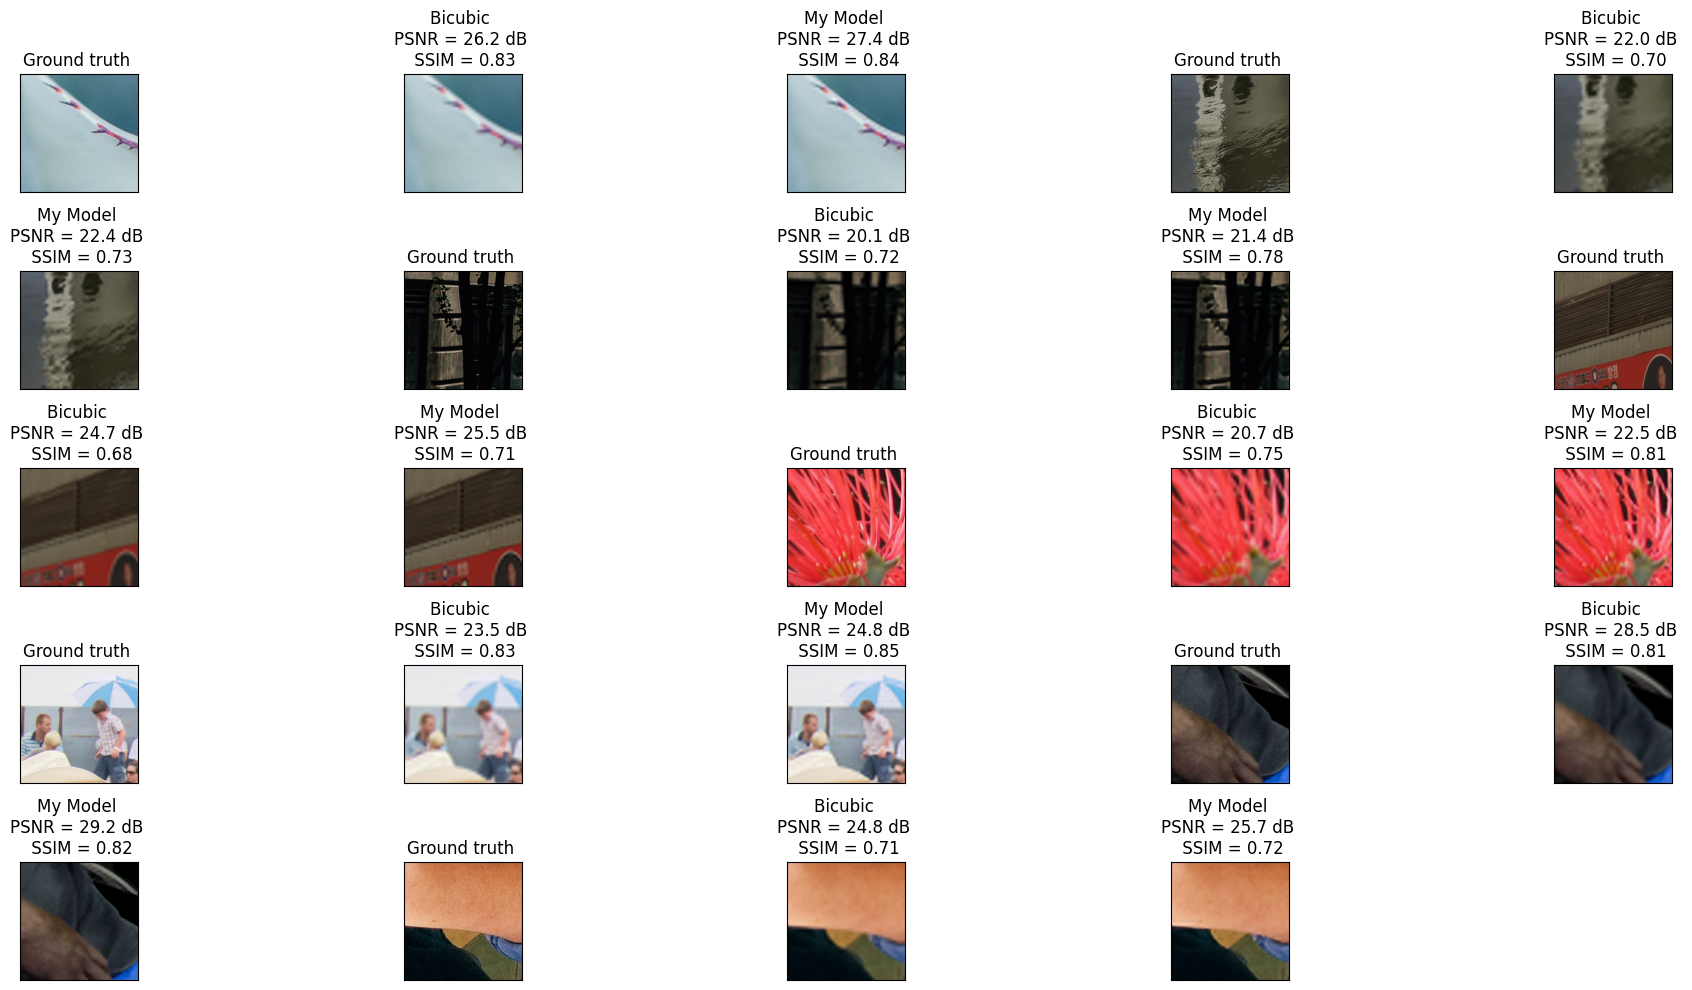

In [ ]:
plot_results(8,cf_models=True)

**Evaluate the Model**

Mean PSNR improvement =  0.8784102243185044  dB
Mean SSIM improvement =  0.03429109167307615


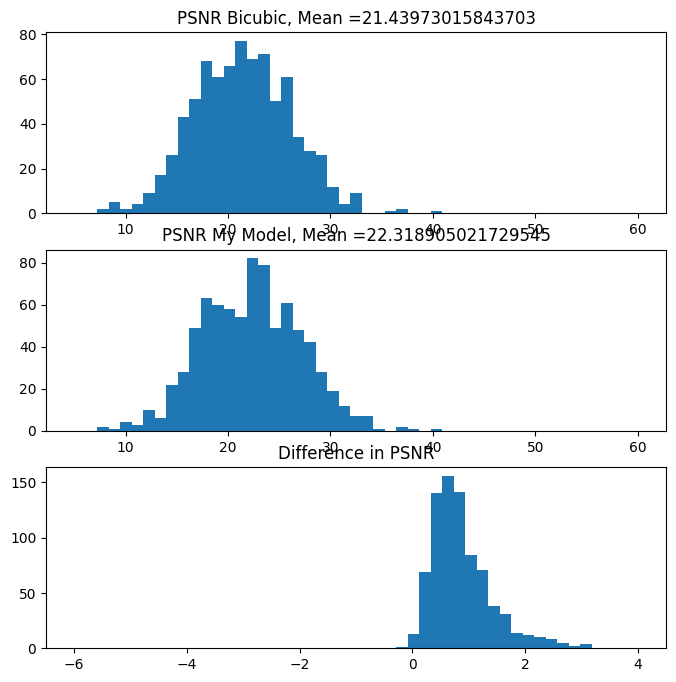

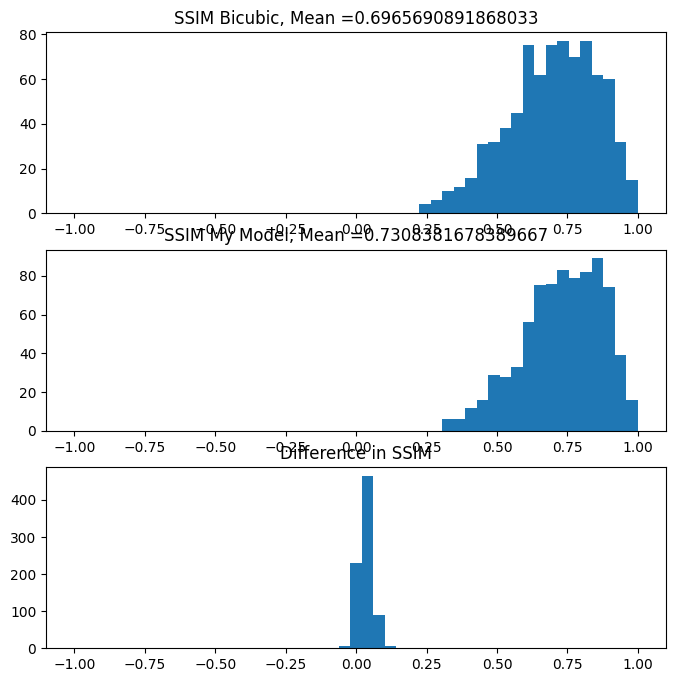

In [ ]:
eval_metrics()

# You may Leave a note here explaining your approach/results for the e-moderator.

The foundation of the models trained above is based on Dong et al paper. I have tried different models by varying the number of filters and their dimensions. The keytakes aways are the following: the increase in the number of filters at different layers results in the slight degradation of PSNR and SSIM, and this results is not conssitent with the result presented in the paper. The results demonstarte that the increase in the dimension of layer 2 kernel from 1 x 1 to 5 x 5 significantly improves PSNR and SSIM.


**In the following I will try another model that applies upscaling after all convolutions have been done.**

In [15]:
# Define Your Model (Ensure that you call your model "my_model" for compatibilty with later plotting function)

# Sequential model will be created as I feel it is more readable
'''
Initially, I will try hyper-parameters mentioned in Dong et al paper
'''
d = 56
s = 12
m = 2

my_model = keras.Sequential([
    keras.layers.Conv2D(56, 5, padding = "same", activation = keras.layers.PReLU(), input_shape = (56, 56, 3)),
    keras.layers.Conv2D(s, 1, padding = "same", activation = keras.layers.PReLU()),
    keras.layers.Conv2D(s, 3, padding = "same", activation = keras.layers.PReLU()),
    keras.layers.Conv2D(s, 3, padding = "same", activation = keras.layers.PReLU()),
    keras.layers.Conv2D(56, 1, padding = "same", activation = keras.layers.PReLU()),
    #keras.layers.Resizing(HW_trg, HW_trg, interpolation='bicubic')
    keras.layers.Conv2DTranspose(3, 113, padding = "valid")
    #keras.layers.Cropping2D(((28,28), (28,28)))
])

In [16]:
# Compile Model
my_model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam())
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 56)        179872    
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 12)        38316     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 12)        38940     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 12)        38940     
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 56)        176344    
                                                                 
 conv2d_transpose (Conv2DTr  (None, 168, 168, 3)       2145195   
 anspose)                                                        
                                                        

In [17]:
epochs = 2 # You may need additional/fewer epochs depending on your network

history = my_model.fit(train_dataset,epochs=epochs,validation_data=test_dataset)

Epoch 1/2
2168/2168 [==============================] - 752s 336ms/step - loss: 1640.9847 - val_loss: 1177.8124
Epoch 2/2
2168/2168 [==============================] - 729s 336ms/step - loss: 1135.4928 - val_loss: 1004.4493


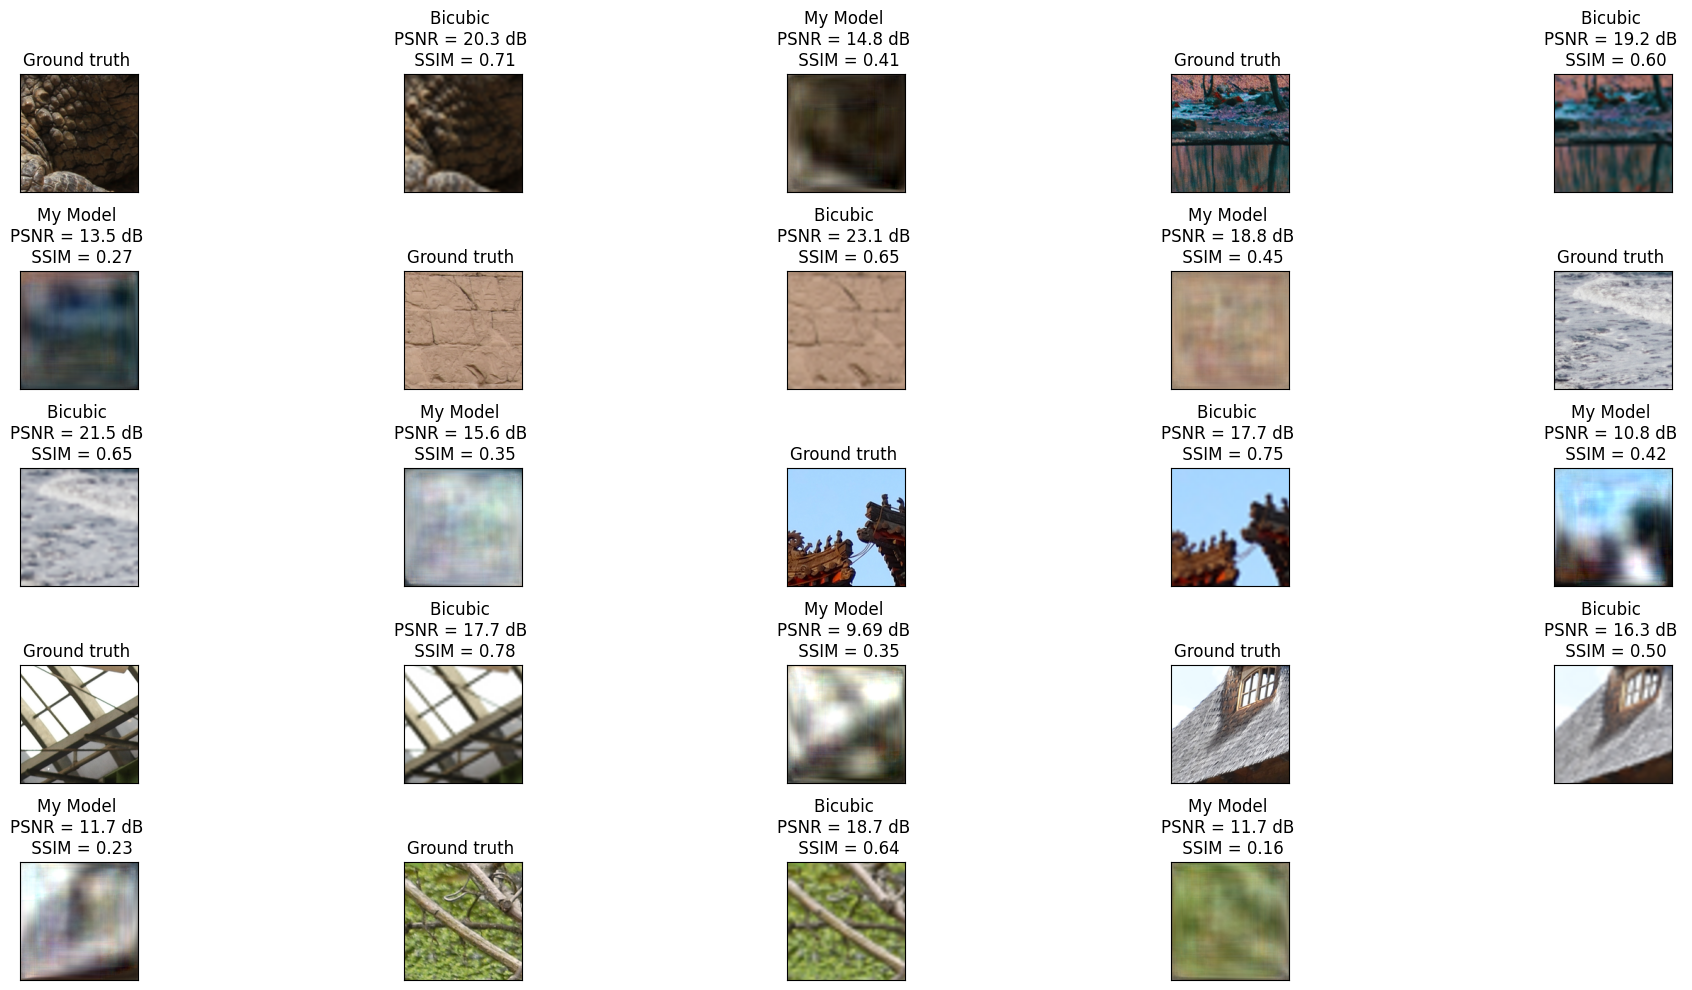

In [18]:
plot_results(8,cf_models=True)

**The new model doesn't seem to perform well. The reason could be that I have only used 2 epochs. However, it can be concluded here that Dong et. al model demonstartes the best results.**